In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import make_scorer,f1_score

current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)
root_path = '/content/gdrive/Othercomputers/My Computer/Fire_risk_main/data/hongru_share/'
raw_data_path= root_path + '/raw_data/'
fire_spread_processed_save_path= root_path + '/step_2/fire_spread/processed_data/'
step2_fs_results_save_path = root_path + '/step_2/fire_spread/results/'

In [ ]:
import sys
print(sys.version)

!pip show catboost

!pip show scikit-learn


3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Name: catboost
Version: 1.2.7
Summary: CatBoost Python Package
Home-page: https://catboost.ai
Author: CatBoost Developers
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: graphviz, matplotlib, numpy, pandas, plotly, scipy, six
Required-by: 
Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License
        
        Copyright (c) 2007-2024 The scikit-learn developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistribut

In [ ]:
package_versions = {
    'pandas': pd.__version__,
    'os': 'builtin',
    'numpy': np.__version__,
    #'catboost': catboost.__version__,
    #'scikit-learn': sklearn.__version__,
    #'matplotlib': matplotlib.__version__,
    'seaborn': sns.__version__,
    'joblib': joblib.__version__
}

package_versions

{'pandas': '2.2.2',
 'os': 'builtin',
 'numpy': '1.26.4',
 'seaborn': '0.13.1',
 'joblib': '1.4.2'}

In [ ]:
filename='df_fs_github.pkl'

In [ ]:
df=pd.read_pickle(fire_spread_processed_save_path + filename)

In [ ]:
df.columns

Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'FIRE_SPRD', 'BLDG_ABOVE',
       'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR',
       'AES_PRES', 'INCIDENT_KEY', 'response_time', 'last_unit_clear_time',
       'accident_year', 'accident_month', 'accident_day', 'accident_hour',
       'median_income_list', 'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
       'AREA_ORIG_new', 'ACT_TAK1_new', 'FACT_IGN1_new', 'HEAT_SOURCE_new',
       'FIRST_IGN_new', 'TYPE_MAT_new', 'PROP_USE_new', 'SUP_FAC_1_new',
       'ITEM_SPRD_new', 'MAT_SPRD_new', 'build_time_1980_to_later_list',
       'solar_or_no_fuel', 'coal_or_wood'],
      dtype='object')

In [ ]:
df.shape

(672338, 46)

In [ ]:
object_columns = df.select_dtypes(include=['object']).columns
print("Object columns:")
print(object_columns)

# Print float columns
float_columns = df.select_dtypes(include=['float']).columns
print("Float columns:")
print(float_columns)

Object columns:
Index(['STATE', 'CAUSE_IGN', 'FIRE_SPRD', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
       'INCIDENT_KEY', 'accident_year', 'accident_month', 'accident_day',
       'accident_hour', 'hum_1', 'AREA_ORIG_new', 'ACT_TAK1_new',
       'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new',
       'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new'],
      dtype='object')
Float columns:
Index(['NUM_UNIT', 'BLDG_ABOVE', 'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG',
       'response_time', 'last_unit_clear_time', 'median_income_list',
       'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone',
       'build_time_1980_to_later_list', 'solar_or

In [ ]:
X = df.drop(columns=[ 'last_unit_clear_time',
                     'FLAME_SPRD', 'FIRE_SPRD'])
y = df['FIRE_SPRD']
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2042)


train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)


In [ ]:
model = CatBoostClassifier(iterations=1500, depth=6,
                           learning_rate=0.1, l2_leaf_reg=5,
                            class_weights=[1, 3, 1, 4],
                           task_type='GPU',
                           loss_function='MultiClass',
                           random_state=2042)
model.fit(train_data, verbose=100)
# y_pred = model.predict(X_)

0:	learn: 1.3446030	total: 40.7ms	remaining: 1m 1s
100:	learn: 1.0863224	total: 2.13s	remaining: 29.6s
200:	learn: 1.0698615	total: 4.01s	remaining: 25.9s
300:	learn: 1.0610374	total: 8.51s	remaining: 33.9s
400:	learn: 1.0541763	total: 10.4s	remaining: 28.4s
500:	learn: 1.0484772	total: 12.2s	remaining: 24.3s
600:	learn: 1.0430520	total: 14.1s	remaining: 21s
700:	learn: 1.0380948	total: 15.9s	remaining: 18.1s
800:	learn: 1.0331061	total: 17.7s	remaining: 15.5s
900:	learn: 1.0286229	total: 22.3s	remaining: 14.8s
1000:	learn: 1.0243275	total: 24.1s	remaining: 12s
1100:	learn: 1.0194739	total: 26s	remaining: 9.44s
1200:	learn: 1.0151289	total: 27.9s	remaining: 6.95s
1300:	learn: 1.0107883	total: 29.8s	remaining: 4.55s
1400:	learn: 1.0068095	total: 31.6s	remaining: 2.23s
1499:	learn: 1.0024687	total: 36.2s	remaining: 0us


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.72      0.74      0.73    101229
           3       0.24      0.37      0.29     23084
           4       0.61      0.42      0.50     67546
           5       0.26      0.40      0.31      9843

    accuracy                           0.57    201702
   macro avg       0.46      0.48      0.46    201702
weighted avg       0.61      0.57      0.58    201702



In [ ]:
step2_fs_results_save_path = root_path + '/step_2/fire_spread/results/'

# Create a dictionary to store the prediction accuracy details
prediction_accuracy = {}
y_pred_series = pd.Series(y_pred.flatten()).reset_index(drop=True)
# Add the 'state', 'y_test', and 'y_pred' to the dictionary
prediction_accuracy['state'] = X_test['STATE'].reset_index(drop=True)  # Use reset_index to align with the test set
prediction_accuracy['INCIDENT_KEY'] = X_test['INCIDENT_KEY'].reset_index(drop=True)  # Use reset_index to align with the test set
prediction_accuracy['y_test'] = y_test.reset_index(drop=True)
prediction_accuracy['y_pred'] = y_pred_series
# Optionally, convert it to a DataFrame for easier analysis
prediction_accuracy_df = pd.DataFrame(prediction_accuracy)
prediction_accuracy_df.to_pickle(os.path.join(step2_fs_results_save_path, 'prediction_accuracy_df_fs_cat_best_gpuv6.pkl'))

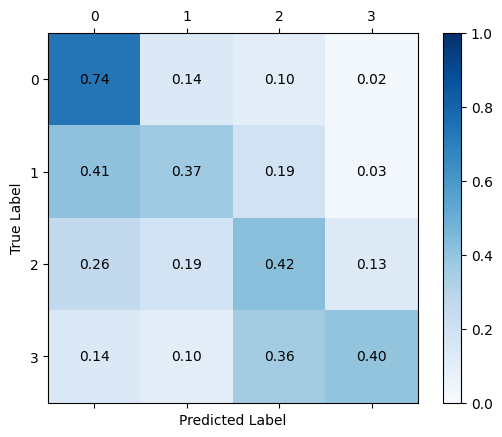

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues, vmin=0, vmax=1)

fig.colorbar(cax)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

In [ ]:
!pip install shap


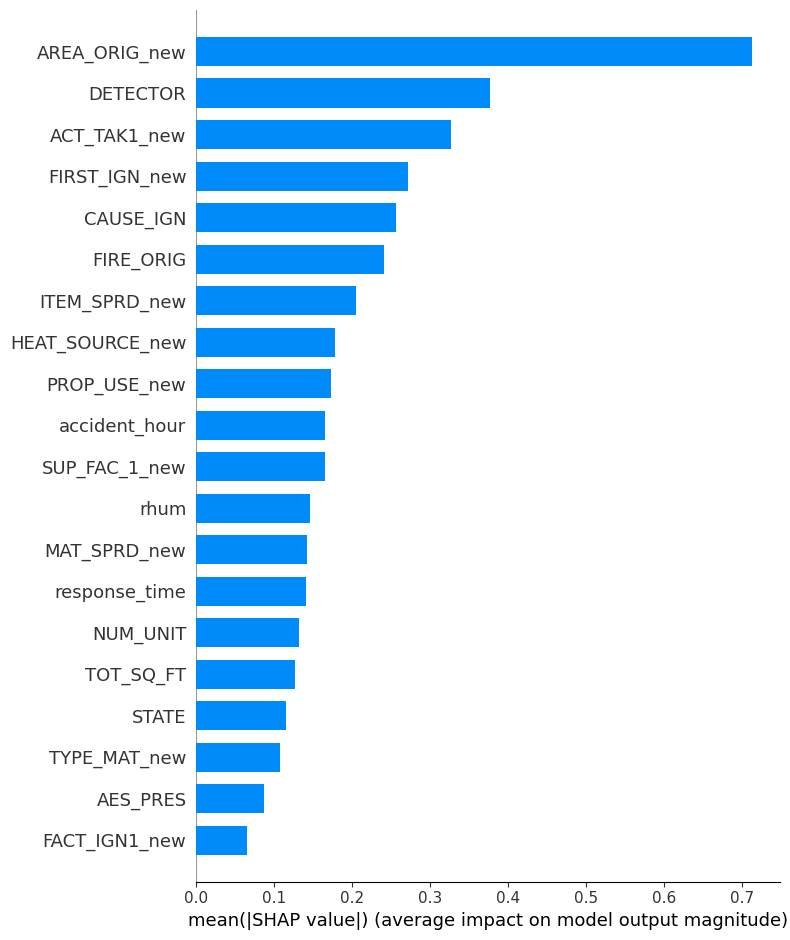

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,0], X_test,plot_type='bar')

In [ ]:
joblib.dump(model, os.path.join(step2_fs_results_save_path, 'model_cont_fs_cat_best_gpuv6.pkl'))
X_test.to_pickle(os.path.join(step2_fs_results_save_path, 'X_test_fs_cat_best_gpuv6.pkl'))
y_test.to_pickle(os.path.join(step2_fs_results_save_path, 'y_test_fs_cat_best_gpuv6.pkl'))
joblib.dump(shap_values, os.path.join(step2_fs_results_save_path, 'shap_values_fs_cat_best_gpuv6.pkl'))
probs = model.predict_proba(X_test)
joblib.dump(probs, os.path.join(step2_fs_results_save_path, 'y_prob_fs_cat_best_gpuv6.pkl'))


['/content/gdrive/Othercomputers/My Computer/Fire_risk_main/data/hongru_share//step_2/fire_spread/results/y_prob_fs_cat_best_gpuv6.pkl']